# Survival output test
Testare il predict dei modelli, vorrei avere una predizione a piu' tempi sensata per i modelli che la supportano. Sarebbe carino anche sapere che tipo di output e', perche' per esempio antolini dovrebbe prendere una survival, altre metriche magari hanno bisogno di altro?

Magari si puo' mettere altri metodi, tipo predict_survival, predict_failure, predict_hazard e predict_density per i metodi che lo supportano, con il predict normale che resta generico. Per farlo bisognerebbe esaminare ad uno ad uno i vari metodi

In [1]:
import numpy
import pandas
import sklearn

In [2]:
import survwrap

In [3]:
X, y = survwrap.load_test_data()
X.shape, y.shape

((198, 84), (198,))

In [4]:
etimes = numpy.sort(survwrap.get_time(y)[survwrap.get_indicator(y)])
etimes

array([ 125.,  269.,  289.,  394.,  404.,  421.,  434.,  524.,  528.,
        530.,  649.,  690.,  723.,  730.,  794.,  796.,  803.,  805.,
        880.,  910.,  994., 1023., 1112., 1136., 1171., 1206., 1233.,
       1259., 1598., 1693., 1721., 1731., 1742., 1743., 1815., 2349.,
       2454., 2604., 2863., 3121., 3313., 3822., 3976., 4050., 4066.,
       4212., 4353., 4415., 4618., 6777., 7185.])

In [5]:
ltime = numpy.linspace(0, etimes.max() * 1.1, num=100)

In [6]:
def plot_output(method, X, time):
    pred = method(X, time)
    #print(pred.shape, X.shape, time.shape)
    pred = pandas.DataFrame(
        pred, 
        index=X.index if hasattr(X, 'index') else [f'Ind{i}' for i, _ in enumerate(X)],
        columns=pandas.Index(time, name='time'),
    )

    pred.T.plot()

In [7]:
def test_model(m):
    assert m.predict(X).shape == (len(X),)

    surv = m.predict_survival(X, etimes[0])
    assert surv.shape == (len(X),)

    surv = m.predict_survival(X, etimes)
    assert surv.shape == (len(X), len(etimes)), f'bad predicted survival probability shape {surv.shape}, expected {(len(X), len(etimes))}'
    assert surv.min() >= 0.0, f'found {(surv < 0).mean():.%} negative values in predicted survival probabilities'
    assert surv.max() <= 1.0, f'{(surv > 1).mean():.%} of predicted survival probabilities are greater than 1'

    #fail = m.predict_failure(X, etimes)
    #err = 1.0 - surv - fail
    #assert (numpy.abs(err) < 0.0000001).all()

## CoxNet

In [8]:
coxnet = survwrap.CoxNet(rng_seed=2309)
coxnet.fit(X, y)

CoxNet(rng_seed=2309, alpha=None, l1_ratio=0.5)

In [9]:
sf = coxnet.model_.predict_survival_function(X[:10])[0]
numpy.interp([0, 1.0, 124.0, 125.0, 126., 599., 20000., 10e6], sf.x, sf.y, left=1, right=0)
numpy.interp(etimes, sf.x, sf.y, left=1, right=0)


array([9.89506723e-001, 9.79071252e-001, 9.61509613e-001, 9.31620983e-001,
       8.82998017e-001, 8.16680580e-001, 7.43399287e-001, 6.57472325e-001,
       5.62723273e-001, 4.69867962e-001, 3.74554904e-001, 2.83765392e-001,
       2.12476167e-001, 1.41419515e-001, 9.03014278e-002, 4.64781947e-002,
       2.09676628e-002, 8.14064636e-003, 3.15102230e-003, 1.01181365e-003,
       2.75844741e-004, 5.90590821e-005, 1.26103164e-005, 1.91088702e-006,
       1.98538325e-007, 1.72509349e-008, 1.49739975e-009, 9.20794316e-011,
       3.78021102e-012, 1.06457063e-013, 1.38356573e-015, 1.12575409e-017,
       6.87388750e-020, 1.87093929e-022, 2.96018112e-025, 2.97147101e-028,
       2.91464661e-031, 1.70131697e-034, 3.05807909e-038, 2.90587162e-043,
       6.03191861e-049, 4.30048560e-056, 1.17256424e-064, 1.16812171e-073,
       3.36425047e-083, 2.93209250e-093, 3.12386936e-105, 3.31060345e-117,
       4.53070689e-130, 4.28762717e-222, 0.00000000e+000])

In [10]:
test_model(coxnet)

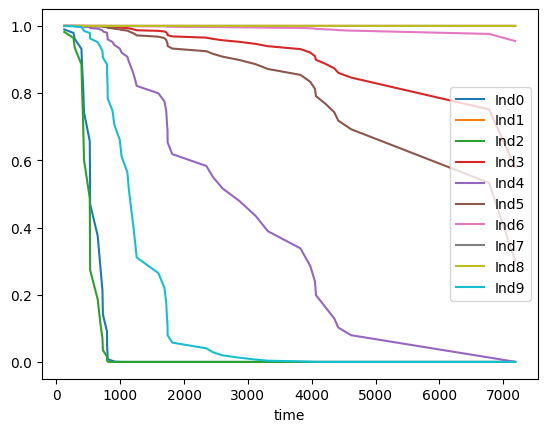

In [11]:
plot_output(coxnet.predict_survival, X[:10], etimes)

In [12]:
#plot_output(coxnet.model_.predict_cumulative_hazard_function, X[:10], etimes)

## DeepHit

Fixme model should run without arguments, gives an error about the seed

In [13]:
try:
    deephit = survwrap.DeepHitSingle()
    deephit.fit(X, y)
except ValueError as e:
    print(e)
    print('model should work without parameters!')

Seed must be between 0 and 2**32 - 1
model should work without parameters!


In [14]:
deephit = survwrap.DeepHitSingle(rng_seed=0, epochs=1)
deephit.fit(X, y)

/data/gbirolo/survwrap/.venv/lib/python3.8/site-packages/torchtuples/callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data = p.data.add(-weight_decay * eta, p.data)


DeepHitSingle(rng_seed=0, num_durations=10, layer_sizes=[10, 10], epochs=1, batch_size=16, validation_size=0.1, learning_rate=0.001, dropout=0.1, device='cpu')

In [15]:
test_model(deephit)

In [17]:
#plot_output(deephit.predict_failure, X[:10], etimes)

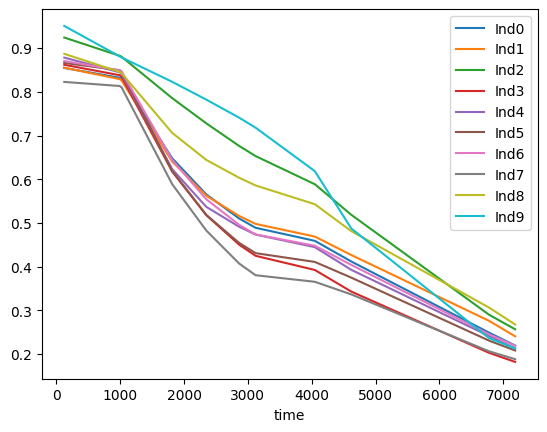

In [18]:
plot_output(deephit.predict_survival, X[:10], etimes)

In [19]:
deephit.predict(X[:10])

array([0.5687112 , 0.55596285, 0.45258137, 0.63661292, 0.58587579,
       0.61028149, 0.57792761, 0.65157557, 0.49336122, 0.45867023])

## Auton

In [20]:
survmach = survwrap.DeepSurvivalMachines()
survmach.fit(X, y)

  0%|          | 0/10000 [00:00<?, ?it/s]

 50%|█████     | 50/100 [00:01<00:01, 30.72it/s]


DeepSurvivalMachines(rng_seed=-1, n_distr=2, distr_kind='Weibull', batch_size=32, layer_sizes=[10, 10], learning_rate=0.001, validation_size=0.1, max_epochs=100, elbo=False)

In [21]:
survmach.predict_survival(X[:10], etimes[0])

array([0.98646375, 0.98153636, 0.97566754, 0.97834987, 0.97710499,
       0.98969404, 0.97393882, 0.98947476, 0.98424269, 0.97202798])

In [22]:
test_model(survmach)


Strange behaviour of DSM...

In [23]:
(
    survmach.model_.predict_survival(X[:10], etimes.tolist()).shape, 
    survmach.model_.predict_survival(X[:10], etimes).shape,
)

/data/gbirolo/survwrap/.venv/lib/python3.8/site-packages/auton_survival/models/dsm/losses.py:341: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  t_horz = torch.tensor(t_horizon).double().to(logits.device)


((10, 51), (10, 1))

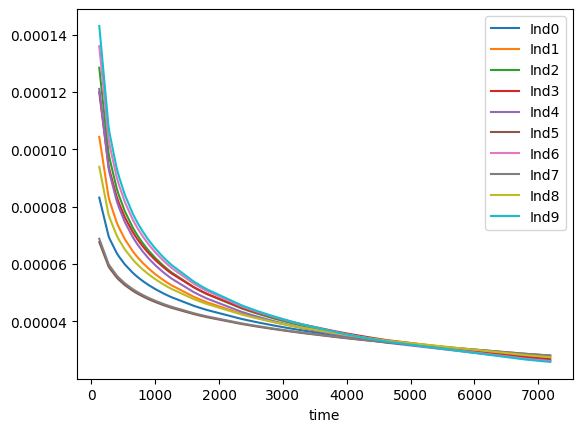

In [24]:
plot_output(survmach.model_.predict_pdf, X[:10], etimes.tolist())

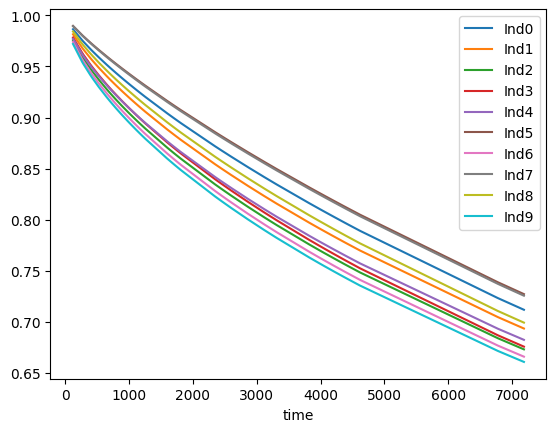

In [25]:
plot_output(survmach.model_.predict_survival, X[:10], etimes.tolist())

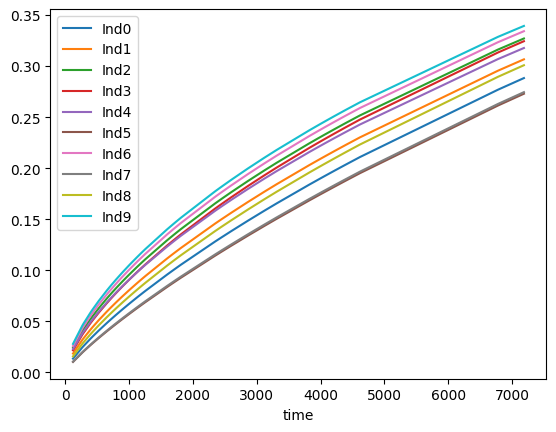

In [26]:
plot_output(survmach.model_.predict_risk, X[:10], etimes.tolist())

In [27]:
survmach.model_.predict_mean(X[:10])

array([  600808.10721405,  2212614.07099777,  6361373.74999059,
        2726875.53647181,  6138211.7605122 ,   254399.60252564,
        7267080.06946529,   275360.91756206,  1091097.91525827,
       10248223.24054556])

In [28]:
survmach.predict(X[:10], etimes)

array([0.20315404, 0.22241521, 0.24387774, 0.23970731, 0.23508947,
       0.18743721, 0.25112819, 0.18890866, 0.2153226 , 0.25672293])